# Assignment 3

## LOG 
- GitHub repository: https://github.com/heitonn/heitonn-ind320-streamlit
- Streamlit app (deployed): https://heitonn-ind320-app-djubejzwip5rtzkik5276s.streamlit.app/

### API and weather data 
Used the historical weather API and the python code provided to retreieve weather data for Bergen 2021. Then I performed a small exploratory data analysis (EDA) to get an overview of the dataset:
- inspecting the general structure
- summary statistics of the data using df.info() df.describe()
- checking seasonal coverage by verifying summer/winter time. 

### Bergen weather data - Temperature
#### Temperature and SATV 
I started with plotting temperature as a function of time. To extract day-to-day variations while removing seasonal trends, I applied a high-pass filter using Direct Cosine Transformation (DCT):
- The temperature data was transformed to the frequency domain.
- The 50 lowest frequencies, corresponding to slow seasonal variations, were set to zero.
- The data was then reconstructed, resulting in Seasonally Adjusted Temperature Variations (SATV).

I experimented with different cutoff values (10, 30, 50, 100) to observe their effect on SATV. A cutoff of 50 was consistent with theoretical expectations for seasonal variation.

To detect outliers, I used robust statistics:
- Median to represent central tendency.
- Median Absolute Deviation (MAD) to define upper and lower SPC boundaries.
- Outliers were then highlighted on a plot of temperature with SATV.

#### Bergen Weather Data – Precipitation
For precipitation, I plotted the data over time and detected anomalies using the Local Outlier Factor (LOF):
- Tested different numbers of neighbors (n_neighbors) to ensure stable detection.
- Highlighted anomalous points on the plot.
### ELHUB energy data
I downloaded data using the Elhub API and wrote the extracted data to a CSV- file, elhub_production.csv. The file contains hourly production data for different Norwegian price areas and production groups (hydro, thermal, solar, etc.). The data was preprocessed to ensure:
- Correct datetime format (startTime)
- Filtering by area and production group
#### Seasonal Trend Decomposition (STL)
Performed STL decomposition (LOESS) on Elhub production data to separate trend, seasonal, and residual components. Parameters such as period, seasonal smoother, trend smoother, and robustness were configurable.

This allowed visualization of both short-term fluctuations and longer-term seasonal patterns in electricity production.

#### Spectogram Analysis 
To analyze frequency content of the production data over time, I implemented a spectrogram:
- Configurable window length and overlap.
- Optional log scaling or normalization for improved visualization.
- Can filter to specific months for targeted analysis.

### Streamlit app
I've become more friendly with streamlit during this project. It took a while to find the right structure for the pages and good solutions for effective data handling and code used in several of the pages. I created a utils folder with functions for data loading and helper functions which is used in several of the pages. Two new pages with tabs layout with functions building on the functions in this notebook. Energy Data: STL decompostion and spectrogram of energy production data for each production group in each price area Weather Anomalies Detection: Temperature (SPC) and percipitation (LOF) for each time period in each of the price areas AI usage 



### AI usage
As always, my friend ChatGPT has been a valuable contributor to this project. I prefer not to use GitHub Copilot when learning new concepts, as it often auto-completes code before I have the chance to fully think through the logic. During the notebook part of the project i have mostly used code from the IND320 book, tried to make it work on my project and then asked ChatGPT for help on occasions. I have used copilot for the finishing touches in the streamlit app and plotting.

# Notebook

## Import 
Importing necessary libaries and extensions 

In [3]:
import pandas as pd 
import requests
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import openmeteo_requests
import requests_cache
from retry_requests import retry
import scipy

from sklearn.neighbors import LocalOutlierFactor
from scipy.fft import dct, idct
from statsmodels.tsa.seasonal import STL
from scipy.signal import spectrogram

## Retrieveing data

Creating a dataframe consiting of the five cities, Oslo, Kristiansand, Trondheim, Tromsø and Bergen, 
icluding their longitude an lattitud and energy price area.

In [4]:
#Saving price area codes, city names, longitude and latitude in a Pandas data frame.

data = [
    ['NO1', 'Oslo', 10.7522, 59.9139],
    ['NO2', 'Kristiansand', 8.0000, 58.1467],
    ['NO3', 'Trondheim', 10.3951, 63.4305],
    ['NO4', 'Tromsø', 18.9553, 69.6496],
    ['NO5', 'Bergen', 5.3221, 60.39299],
]

df = pd.DataFrame(data, columns=['PriceArea', 'City', 'Longitude', 'Latitude'])
print(df)

  PriceArea          City  Longitude  Latitude
0       NO1          Oslo    10.7522  59.91390
1       NO2  Kristiansand     8.0000  58.14670
2       NO3     Trondheim    10.3951  63.43050
3       NO4        Tromsø    18.9553  69.64960
4       NO5        Bergen     5.3221  60.39299


Retrieving historical weather data from Bergen 2019 with open meteo API. 
- temperature 2m
- precipitation
- wind speed 10 m 
- wind gusts 10 m 
- wind direction 10 m

In [5]:
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

In [6]:
# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 60.393,
	"longitude": 5.3242,
	"start_date": "2019-01-01",
	"end_date": "2019-12-31",
	"hourly": ["temperature_2m", "precipitation", "wind_speed_10m", "wind_gusts_10m", "wind_direction_10m"],
}
responses = openmeteo.weather_api(url, params=params)

# Response check
if len(responses) > 0:
    print('Success')
else: 
    print('No data fetched ')

Success


In [ ]:
# Process Bergen weather data 
response = responses[0]
print(f"Coordinates: {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation: {response.Elevation()} m asl")
print(f"Timezone difference to GMT+0: {response.UtcOffsetSeconds()}s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_precipitation = hourly.Variables(1).ValuesAsNumpy()
hourly_wind_speed_10m = hourly.Variables(2).ValuesAsNumpy() 
hourly_wind_gusts_10m = hourly.Variables(3).ValuesAsNumpy()
hourly_wind_direction_10m = hourly.Variables(4).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end =  pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}

hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["precipitation"] = hourly_precipitation
hourly_data["wind_speed_10m"] = hourly_wind_speed_10m
hourly_data["wind_gusts_10m"] = hourly_wind_gusts_10m
hourly_data["wind_direction_10m"] = hourly_wind_direction_10m

hourly_dataframe = pd.DataFrame(data = hourly_data)
print("\nHourly data\n", hourly_dataframe)


Coordinates: 60.421791076660156°N 5.2941179275512695°E
Elevation: 17.0 m asl
Timezone difference to GMT+0: 0s

Hourly data
                           date  temperature_2m  precipitation  wind_speed_10m  \
0    2019-01-01 00:00:00+00:00           5.772            0.2       41.036842   
1    2019-01-01 01:00:00+00:00           6.072            0.7       42.033756   
2    2019-01-01 02:00:00+00:00           6.322            0.5       40.913490   
3    2019-01-01 03:00:00+00:00           5.822            1.1       41.238468   
4    2019-01-01 04:00:00+00:00           5.722            0.7       44.140755   
...                        ...             ...            ...             ...   
8755 2019-12-31 19:00:00+00:00           4.972            0.7       11.525623   
8756 2019-12-31 20:00:00+00:00           5.872            0.7       12.984975   
8757 2019-12-31 21:00:00+00:00           6.372            0.3       14.618837   
8758 2019-12-31 22:00:00+00:00           6.122            0.1     

In [8]:
hourly_dataframe.describe()

,temperature_2m,precipitation,wind_speed_10m,wind_gusts_10m,wind_direction_10m
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,7.828758,0.246450,10.685799,29.520823,186.511353
std,5.999574,0.583147,6.047772,16.090151,96.201706
min,-12.878000,0.000000,0.000000,2.520000,1.169115
25%,3.072000,0.000000,6.120000,16.919998,116.564987
50%,7.222000,0.000000,9.531505,26.639999,164.836456
75%,12.084500,0.200000,14.332340,39.599998,279.462250
max,31.722000,9.500000,46.675217,131.040009,360.000000


In [9]:
hourly_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   date                8760 non-null   datetime64[ns, UTC]
 1   temperature_2m      8760 non-null   float32            
 2   precipitation       8760 non-null   float32            
 3   wind_speed_10m      8760 non-null   float32            
 4   wind_gusts_10m      8760 non-null   float32            
 5   wind_direction_10m  8760 non-null   float32            
dtypes: datetime64[ns, UTC](1), float32(5)
memory usage: 239.7 KB


In [ ]:
# Checking for summer time
print(f"SUMMER: {hourly_dataframe.iloc[int(len(hourly_dataframe)/2)].date}")
print("-"*33)
print(f"WINTER: {hourly_dataframe.iloc[0].date}")


SUMMER: 2019-07-02 12:00:00+00:00
---------------------------------
WINTER: 2019-01-01 00:00:00+00:00


In [11]:
date = hourly_dataframe['date'].to_numpy()

# Bergen weather data 

### Temperature 
Starting with a plot of the temperature as a function of time. 


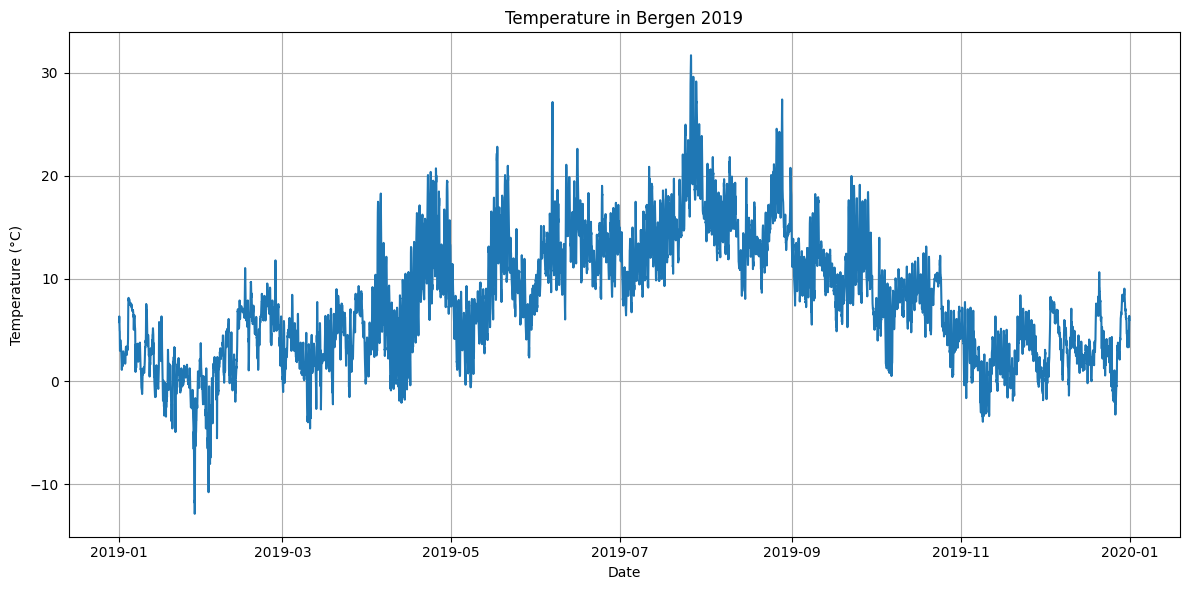

In [12]:
# Plotting temperature as a function of time 

plt.figure(figsize=(12, 6))
plt.plot(date, hourly_temperature_2m, label="Temperature (°C)")

plt.title("Temperature in Bergen 2019")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.tight_layout()
plt.grid(True)


Creating a high pass filter using Direct Cosine Transfer 
 - creates an array where the lower indicies are the slow variating - seasonal variations 
 - Cut off at 50: removes the 50 lowest frequencies - seasonal variations
 - reconstruction the temperaturedata without sesonal variations - SATV



In [13]:
# Calculating direct cosinus transformation
temps_dct = dct(hourly_temperature_2m, norm='ortho')

# High pass filtering 
cutoff = 50   # lower values will remove more season
temps_dct_hp = temps_dct.copy()
temps_dct_hp[:cutoff] = 0  # setting the values lower than cut off to 0 

# reconstructing temperature data 
temps_satv = idct(temps_dct_hp, norm='ortho')


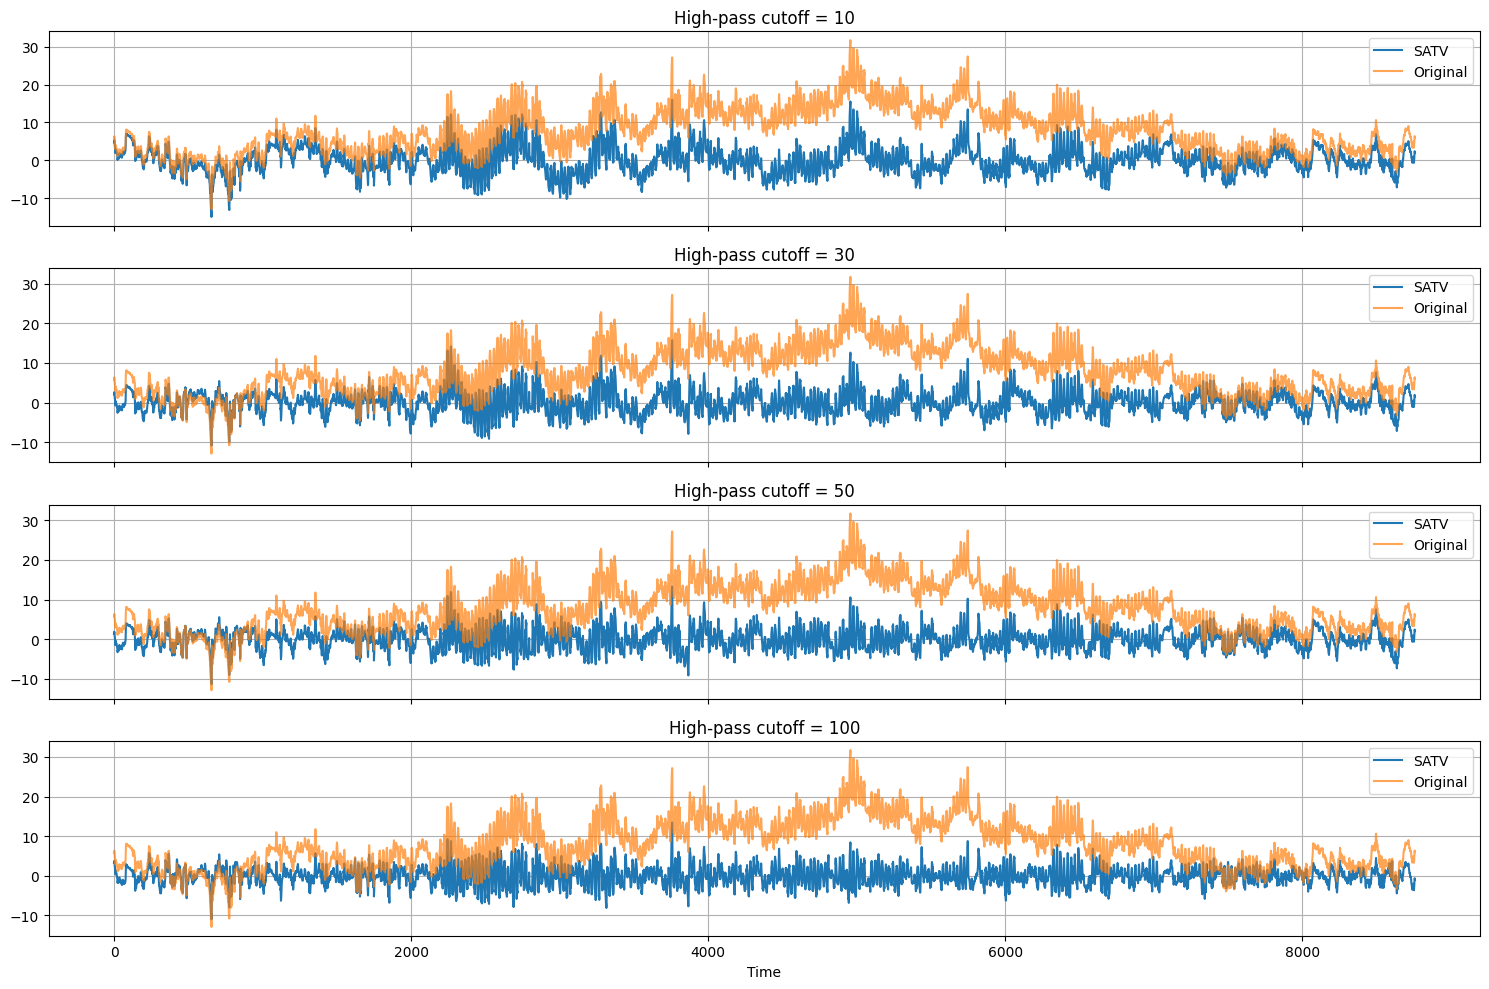

In [14]:
# Observing how different cutoffs will affect the data 
cutoffs = [10, 30, 50, 100]

fig, axes = plt.subplots(len(cutoffs), 1, figsize=(15, 10), sharex=True)

for ax, c in zip(axes, cutoffs):
    temps_dct_hp = temps_dct.copy()
    temps_dct_hp[:c] = 0
    temps_satv = idct(temps_dct_hp, norm='ortho')
    
    ax.plot(temps_satv, label = 'SATV')
    ax.plot(hourly_temperature_2m, label='Original', alpha = 0.7)
    ax.set_title(f'High-pass cutoff = {c}')
    ax.grid(True)
    ax.legend()

axes[-1].set_xlabel('Time')
plt.tight_layout()
plt.show()

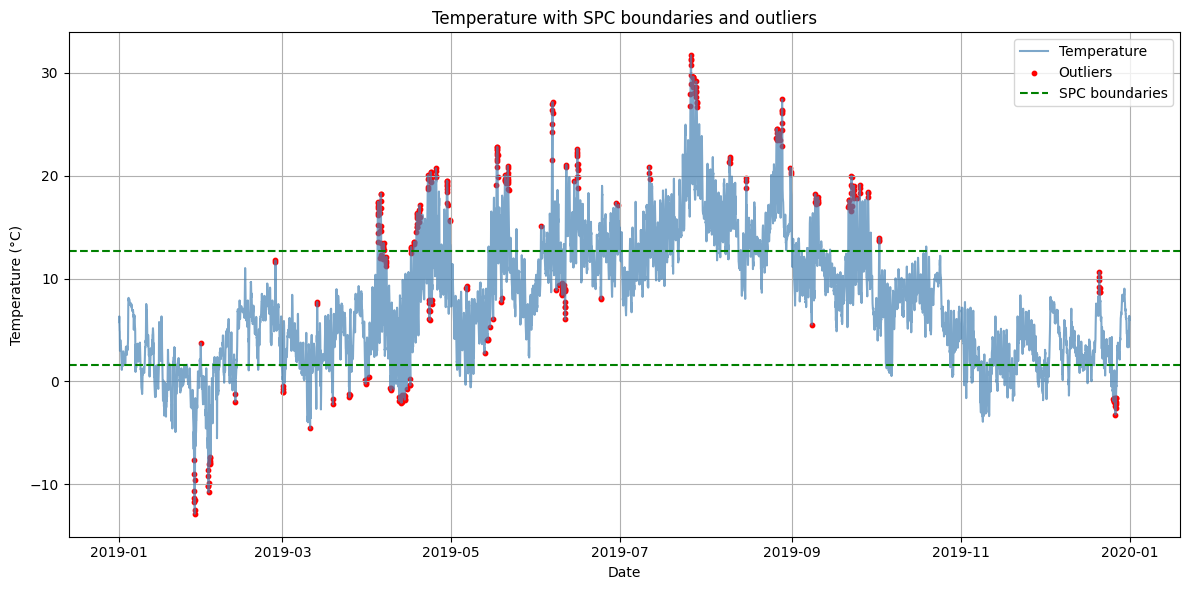

Total points       : 8760
Outlier count      : 348
Outlier percentage : 3.97%
MAD                : 1.86
Upper limit        : 5.50
Lower limit        : -5.65


In [15]:
def plot_temperature_with_spc(df, temp_col="temperature_2m", date_col="date", 
                              cutoff=50, n_std=3):
    """
    Plot temperature over time, add SPC boundaries based on SATV (DCT high-pass filtered signal),
    and highlight outliers.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing date and temperature columns.
        temp_col (str): Name of the temperature column.
        date_col (str): Name of the datetime column.
        cutoff (int): Number of low DCT frequencies to remove (high-pass filter).
        n_std (float): Number of Median Absolute Deviations (MAD) defining SPC boundaries.
    
    Returns:
        outlier_summary (pd.DataFrame): DataFrame with timestamps and temperatures of outliers.
    """
    # Collecting and converting data
    temps = df[temp_col].to_numpy()
    dates = pd.to_datetime(df[date_col]) # converting to pd daytime

    # DCT and high-pass filter
    temps_dct = dct(temps, norm='ortho')
    temps_dct_hp = temps_dct.copy()
    temps_dct_hp[:cutoff] = 0  
    temps_satv = idct(temps_dct_hp, norm='ortho')

    # Robust statistics 
    median_satv = np.median(temps_satv) 
    mad_satv = np.median(np.abs(temps_satv - median_satv)) # Median absolute deviation
    upper_limit = median_satv + n_std * mad_satv # calculating upper boundary
    lower_limit = median_satv - n_std * mad_satv # calculating lower boundary

    # Finding data outside the boundaries
    outliers = (temps_satv > upper_limit) | (temps_satv < lower_limit)
    outlier_df = df.loc[outliers, [date_col, temp_col]].copy()
    outlier_df["SATV_value"] = temps_satv[outliers]

    # Plot
    plt.figure(figsize=(12,6))
    plt.plot(dates, temps, label="Temperature", color="steelblue", alpha=0.7)
    plt.scatter(dates[outliers], temps[outliers], color="red", s=10, label="Outliers")

    baseline = np.median(temps)
    plt.axhline(baseline + upper_limit, color="green", linestyle="--", label="SPC boundaries")
    plt.axhline(baseline + lower_limit, color="green", linestyle="--")

    plt.title("Temperature with SPC boundaries and outliers")
    plt.xlabel("Date")
    plt.ylabel("Temperature (°C)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Summary of statistics
    print(
        f"Total points       : {len(df)}\n"
        f"Outlier count      : {outlier_df.shape[0]}\n"
        f"Outlier percentage : {100 * outlier_df.shape[0] / len(df):.2f}%\n"
        f"MAD                : {mad_satv:.2f}\n"
        f"Upper limit        : {upper_limit:.2f}\n"
        f"Lower limit        : {lower_limit:.2f}"
    )
    return outlier_df


outliers = plot_temperature_with_spc(hourly_dataframe, cutoff=50, n_std=3)



## Precipitation

Starting with plotting precipitation as a function of time. 

Text(0, 0.5, 'Precipitation (mm)')

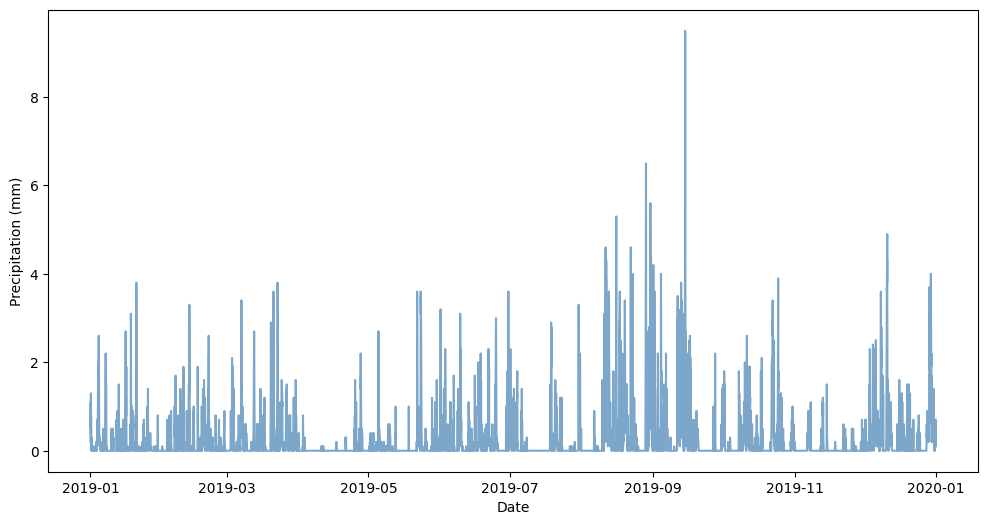

In [16]:
# Plotting precipitation as a function of time
plt.figure(figsize=(12,6))
plt.plot(date, hourly_precipitation, label="Precipitation", color="steelblue", alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Precipitation (mm)')

Detecting anomalies and plotting the using Local Outlier Factor (LOF). 
- Setting default value of conatmination to 1%.
- Defaul value of n_neighbours to 50. 

c:\Users\heito\miniconda3\envs\D2D_env\Lib\site-packages\sklearn\neighbors\_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


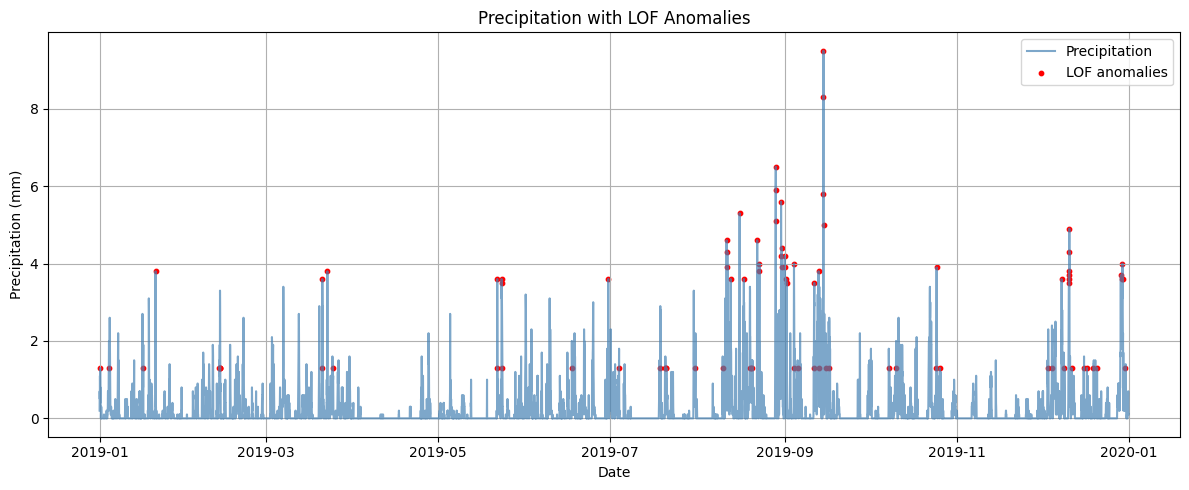

Total points       : 8760
Outlier count      : 87
Outlier percentage : 0.99%


In [17]:
def plot_precipitation_with_lof(df, precip_col="precipitation", date_col="date",
                                n_neighbors=50, contamination=0.01):
    """
    Plot precipitation over time and indicate anomalies using Local Outlier Factor.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing precipitation and date columns
        precip_col (str): Name of precipitation column
        date_col (str): Name of datetime column
        n_neighbors (int): Number of neighbors for LOF (default to 50) 
        contamination (float): Expected proportion of outliers (default 0.01 = 1%)
    
    Returns:
        outlier_df (pd.DataFrame): DataFrame with timestamps and precipitation of detected outliers
    """
    
    # Collecting and converting data
    dates = pd.to_datetime(df[date_col])
    X = df[precip_col].values.reshape(-1, 1)
    
    # Anomaly detection using Local outlier factor (LOF)
    lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination)
    y_pred = lof.fit_predict(X)  # -1 = outlier, 1 = inlier
    anomalies = y_pred == -1
    
    # Creating a DataFrame with only the detected outlier rows
    outlier_df = df.loc[anomalies, [date_col, precip_col]].copy()
    
    # Plotting
    plt.figure(figsize=(12,5))
    plt.plot(dates, df[precip_col], color="steelblue", alpha=0.7, label="Precipitation")
    plt.scatter(outlier_df[date_col], outlier_df[precip_col], color="red", s=10, label="LOF anomalies")
    plt.xlabel("Date")
    plt.ylabel("Precipitation (mm)")
    plt.title("Precipitation with LOF Anomalies")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # --- Summary ---
    total_points = len(df)
    outlier_count = len(outlier_df)
    outlier_percentage = 100 * outlier_count / total_points
    
    print(
        f"Total points       : {total_points}\n"
        f"Outlier count      : {outlier_count}\n"
        f"Outlier percentage : {outlier_percentage:.2f}%"
    )
    
    return outlier_df

# Test function
outliers = plot_precipitation_with_lof(hourly_dataframe, precip_col="precipitation", date_col="date", n_neighbors=50
                                       )



## ELHUB
Reading energy production data from the elhub_production.csv.

In [18]:
# Reading the CSV-file
df = pd.read_csv("elhub_production.csv")

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215353 entries, 0 to 215352
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   area             215353 non-null  object 
 1   productionGroup  215353 non-null  object 
 2   startTime        215353 non-null  object 
 3   quantityKwh      215353 non-null  float64
dtypes: float64(1), object(3)
memory usage: 6.6+ MB


In [20]:
# Converting startTime to datetime 
df['startTime'] = pd.to_datetime(df['startTime'], utc = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215353 entries, 0 to 215352
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype              
---  ------           --------------   -----              
 0   area             215353 non-null  object             
 1   productionGroup  215353 non-null  object             
 2   startTime        215353 non-null  datetime64[ns, UTC]
 3   quantityKwh      215353 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(1), object(2)
memory usage: 6.6+ MB


In [21]:
df.head()

,area,productionGroup,startTime,quantityKwh
0,NO1,hydro,2020-12-31 23:00:00+00:00,2507716.8
1,NO1,hydro,2021-01-01 00:00:00+00:00,2494728.0
2,NO1,hydro,2021-01-01 01:00:00+00:00,2486777.5
3,NO1,hydro,2021-01-01 02:00:00+00:00,2461176.0
4,NO1,hydro,2021-01-01 03:00:00+00:00,2466969.2


### Seasonal-Trend decomposition using LOESS (STL)
Using Seasonal Trend Decomposition using LOESS to visualize the variations in the production data, dividing the data up in:
Trend - longterm variations 
Season - repeating patterns typically day or weekly cycles
Residual/noise - random variations and anomalies that dont follow a pattern  


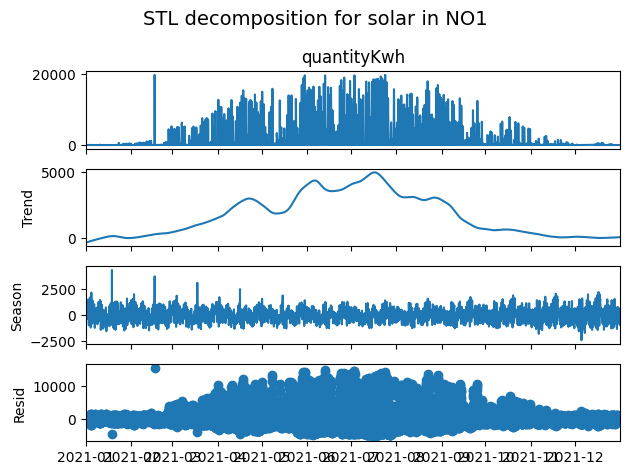

In [ ]:


def plot_stl_decomposition(df, area="NO1", productionGroup="hydro", 
                           period=24, seasonal=13, trend=13, robust=False):
    """
    Perform STL decomposition on elhub production data and plot the result.

    Parameters:
        df (pd.DataFrame): DataFrame with columns area, productionGroup, startTime, quantityKwh
        area (str): Price area, e.g., "NO1"
        productionGroup (str): Production group, e.g., "hydro"
        period (int): Seasonal period (e.g., 24 for daily cycle)
        seasonal (int): Seasonal smoother length
        trend (int): Trend smoother length
        robust (bool): Whether to use robust fitting

    Returns:
        stl (STL): STL object with decomposition
    """
    # Filtering data on area and production group
    df_filtered = df[(df['area'] == area) & (df['productionGroup'] == productionGroup)].copy()
    df_filtered = df_filtered.sort_values('startTime')
    
    # Making a time series
    ts = df_filtered.set_index('startTime')['quantityKwh']
    
    # STL decomposition
    stl = STL(ts, period=period, seasonal=seasonal, trend=trend, robust=robust)
    result = stl.fit()
    
    # Plotting
    result.plot() # Plotting the decomposition results
    plt.suptitle(f"STL decomposition for {productionGroup} in {area}", fontsize=14)
    plt.tight_layout()
    plt.show()
    
    return result


# Test function 
# Period: One day 24 hours - one week 168 hours - one month ~ 720
stl_result = plot_stl_decomposition(df, area="NO1", productionGroup="solar",
                                     period=700, seasonal=711, trend=711)



### Spectrogram
Creating a spectrogram based on the production data from elhub.
The spectogram shows how the frequency og the signal varies over time, the result shows which frequencies that dominates in the different time periods. Added logartimic scale for better visualization of small values


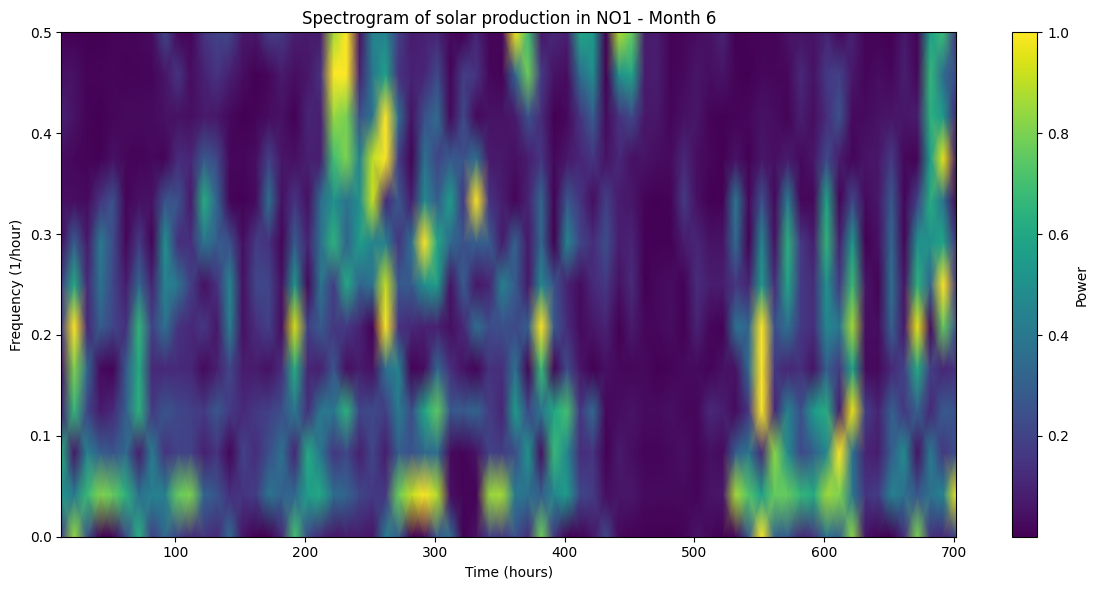

In [ ]:
def plot_production_spectrogram(df, area="NO1", productionGroup="hydro",
                                window_length=168, window_overlap=84, fs=1,
                                month=None, log_scale=True, normalize=False):
    """
    Create a spectrogram from Elhub production data with better visualization.

    Parameters:
        df (pd.DataFrame): DataFrame with columns area, productionGroup, startTime, quantityKwh
        area (str): Price area, e.g., "NO1"
        productionGroup (str): Production group, e.g., "hydro"
        window_length (int): Window length in number of points for FFT
        window_overlap (int): Overlap between windows
        fs (float): Sampling frequency (per hour = 1)
        month (int or None): If specified, plot only this month (1=Jan,...,12=Dec)
        log_scale (bool): If True, use log10 of power for plotting
        normalize (bool): If True, normalize each frequency to max power
    Returns:
        f, t, Sxx: Frequencies, times, and spectrogram power
    """
    
    # Filtering data 
    df_filtered = df[(df['area'] == area) & (df['productionGroup'] == productionGroup)].copy()
    df_filtered = df_filtered.sort_values('startTime')
    
    if month is not None:
        df_filtered = df_filtered[df_filtered['startTime'].dt.month == month]
    
    ts = df_filtered.set_index('startTime')['quantityKwh'].values
    if len(ts) < window_length:
        raise ValueError("Time series is shorter than window length.")
    
    # Spectrogram
    f, t, Sxx = spectrogram(ts, fs=fs, nperseg=window_length, noverlap=window_overlap)
    
    # Normalization
    if normalize:
        Sxx = Sxx / (Sxx.max(axis=1, keepdims=True) + 1e-12)
    
    # Log scale
    if log_scale:
        Sxx_plot = 10 * np.log10(Sxx + 1e-10)
        cbar_label = 'Power (dB)'
    else:
        Sxx_plot = Sxx
        cbar_label = 'Power'
    
    # Plotting
    plt.figure(figsize=(12,6))
    plt.pcolormesh(t, f, Sxx_plot, shading='gouraud') # plotting the spectrogram
    plt.ylabel('Frequency (1/hour)')
    plt.xlabel('Time (hours)')
    title = f"Spectrogram of {productionGroup} production in {area}"
    if month is not None:
        title += f" - Month {month}"
    plt.title(title)
    plt.colorbar(label=cbar_label)
    plt.tight_layout()
    plt.show()
    
    return f, t, Sxx

# Test the function
# Window length: One day 24 hours - one week 168 hours - one month ~ 720
f, t, Sxx = plot_production_spectrogram(df, area="NO1", productionGroup="solar",
                                        window_length=24, window_overlap=14,
                                        month=6, log_scale=False, normalize=True)